inspiration:
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

read this: 
- https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
- https://www.kaggle.com/dansbecker/handling-missing-values
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

1. Тщательный анализ данных.
- Исследовать данные на наличие пропусков и некорректных значений. Либо удалить их, либо сделать imputing (проинтерполировать).
- Посмотреть на распределение целевой переменной. Идентифицировать аномалии. Решить, что делать: убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса). 
- Проанализировать признаки. Отобрать те, которые лично вам кажутся наиболее важными. Посмотреть на их распределение (в том числе на попарные). 
- Посмотреть на совместное распределение целевой переменной и выбранных признаков. 
- Сформулировать гипотезы о том, какие сочетания признаков могут быть полезны. Добавить их (если придумаете). Подсказка: отрисуйте выборку на карте, посчитайте расстояние до важных объектов в этом городе, посчитайте статистики по районам и по ближайшим объектам (не забудьте, что эти статистики нужно считать по обучающей выборке!).

### Find and Handle NaN values or incorrect values

possible incorrect values:
- negative sale price
- negative physical parameters of the house

possible ways to interpolate NaN values:
- remove them
- fill with mean, mode, 0, ...
- interpolate

### Observe SalePrice distribution find outliers

and decide what to do with them

### Analyze features and select most important ones

Observe distributions
Heatmaps

Pair distributions

### Observe distribution of target and selected features

### Generate new features

In [1]:
!conda install pytz -y

Solving environment: done

## Package Plan ##

  environment location: /home/qazybek/miniconda3/envs/ds

  added / updated specs:
    - pytz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.25  |       h06a4308_1         112 KB
    ------------------------------------------------------------
                                           Total:         112 KB

The following packages will be UPDATED:

  ca-certificates                      2021.4.13-h06a4308_1 --> 2021.5.25-h06a4308_1



ca-certificates-2021 | 112 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
train = pd.read_csv('../data/train.csv', index_col='Id')
test = pd.read_csv('../data/test.csv', index_col='Id')

In [4]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:

corr = train.corr()
mask = np.zeros((len(corr), len(corr)))
# build nonzero upper triangle
for i in range(len(corr)):
    for j in range(len(corr)):
        if i > j:
            mask[i, j] = 1        
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])

<AxesSubplot:>

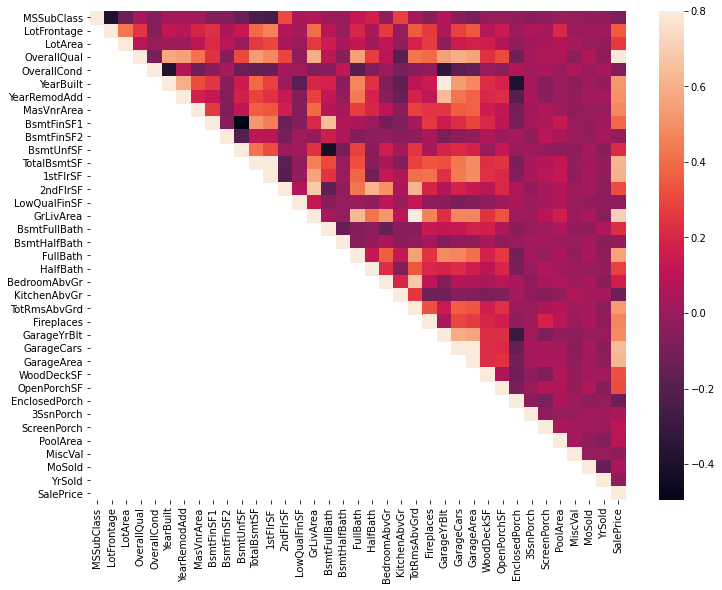

In [8]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=0.8, mask=mask)

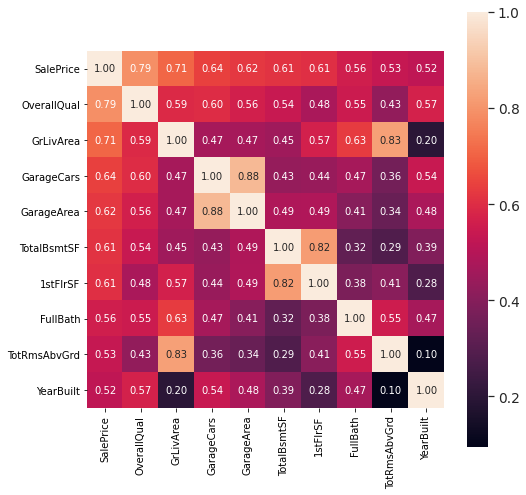

In [9]:
# saleprice correlation matrix
k = 10  # number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [10]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## We can observe some ...

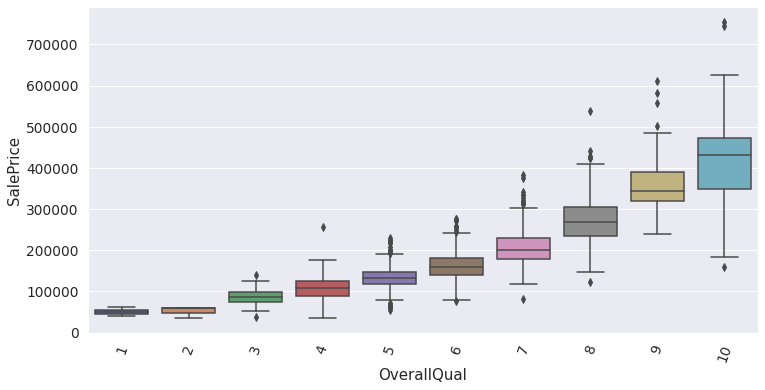

In [11]:
feature = 'OverallQual'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=feature, y="SalePrice", data=data)
plt.xticks(rotation=70);
# fig.axis(ymin=0, ymax=800000);

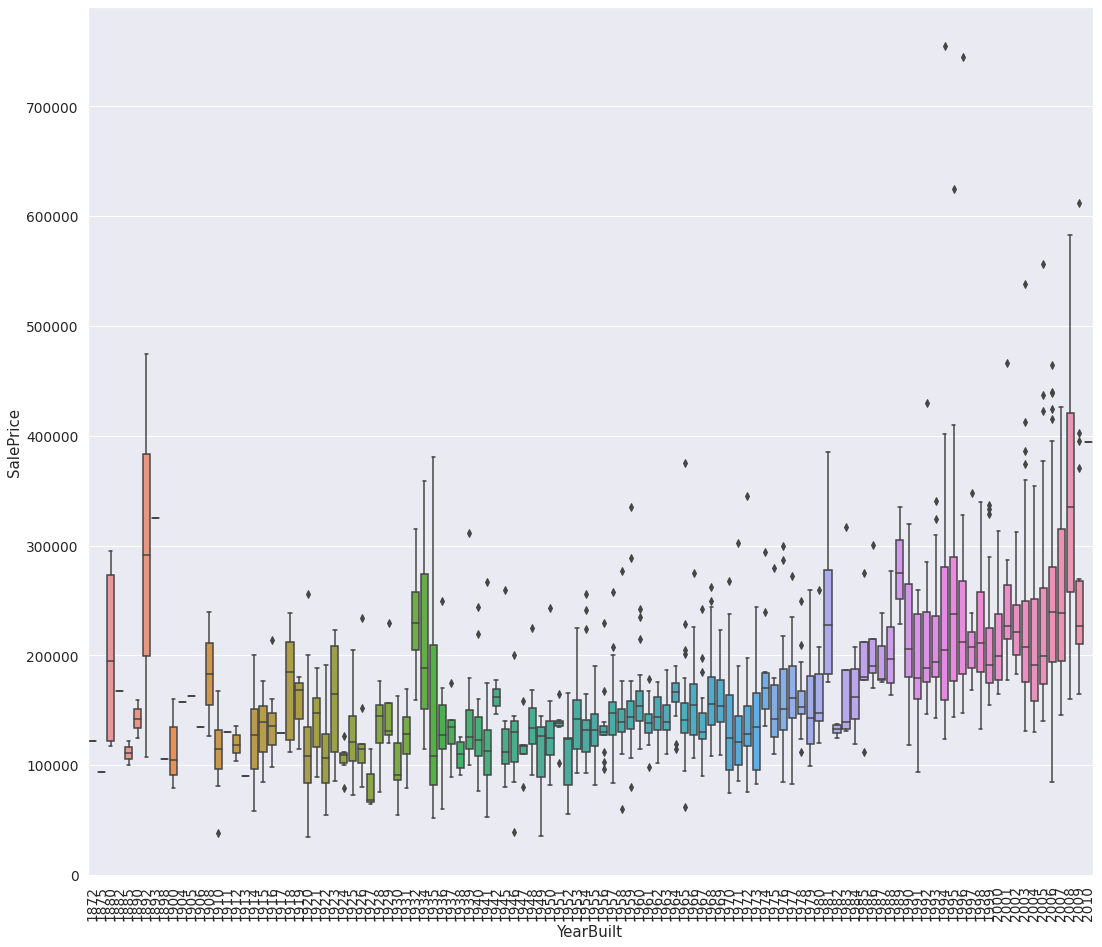

In [12]:
feature = 'YearBuilt'

data = pd.concat([train['SalePrice'], train[feature]], axis=1)
f, ax = plt.subplots(figsize=(18, 16))
fig = sns.boxplot(x=feature, y="SalePrice", data=data)
# fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

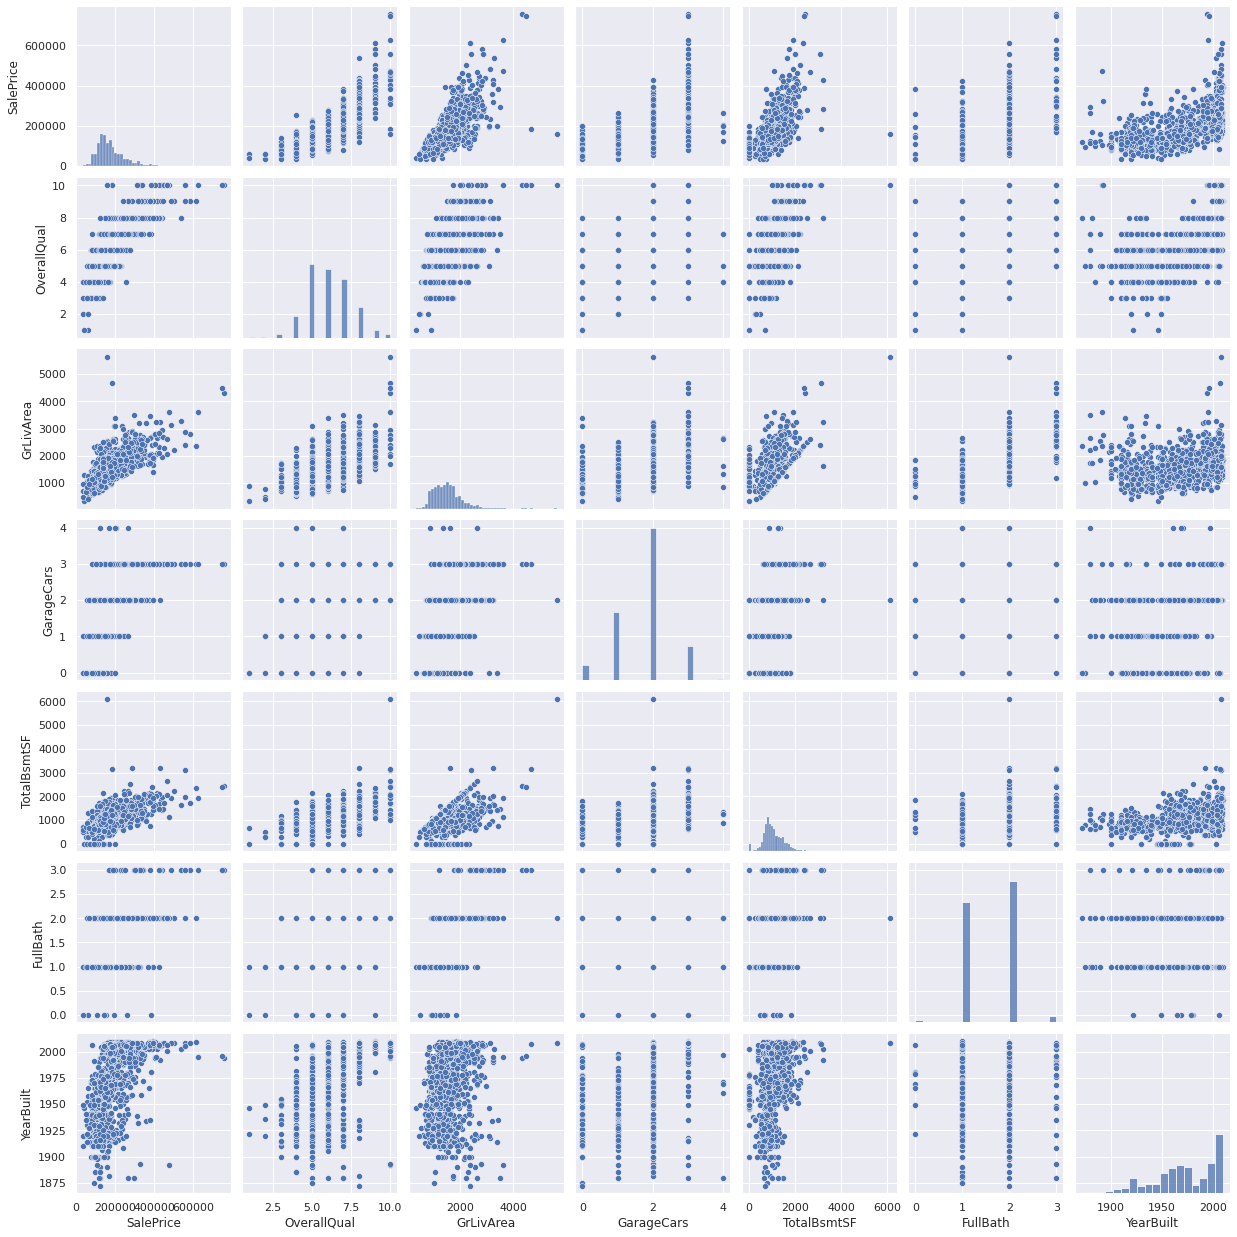

In [13]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

## Skewness normalization

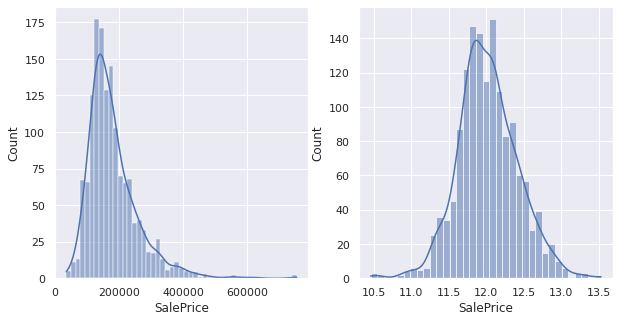

In [14]:
# combination of histogram and kdeplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(train['SalePrice'], ax=ax1, kde=True);
sns.histplot(np.log(train['SalePrice']), ax=ax2, kde=True);

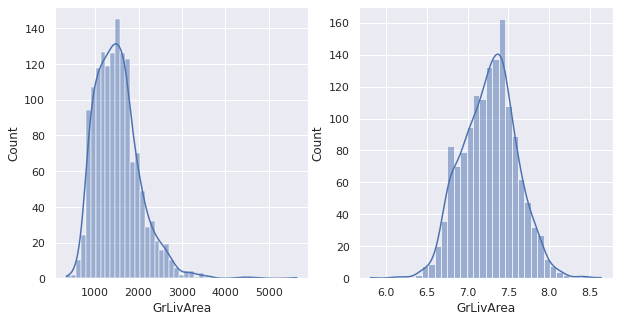

In [15]:
# combination of histogram and kdeplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(train['GrLivArea'], ax=ax1, kde=True);
sns.histplot(np.log(train['GrLivArea']), ax=ax2, kde=True);

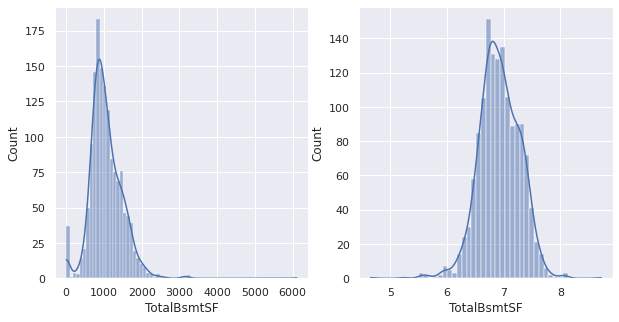

In [16]:
# combination of histogram and kdeplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


TotalBsmtSF_prev = train['TotalBsmtSF'].copy()

sns.histplot(TotalBsmtSF_prev, ax=ax1, kde=True);
sns.histplot(np.log(train[train['TotalBsmtSF']>0]['TotalBsmtSF']), ax=ax2, kde=True);

## Preprocessing

In [17]:
# train.drop(columns=['HasBsmt'], inplace=True)

In [18]:
train_target = train['SalePrice']
train_data= train.drop(columns=['SalePrice'])

In [19]:
train_test = pd.concat([train_data, test], axis=0, sort=False)

In [20]:
# # Converting non-numeric predictors stored as numbers into string

# train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
# train_test['YrSold'] = train_test['YrSold'].apply(str)
# train_test['MoSold'] = train_test['MoSold'].apply(str)

In [21]:
# add new features

### fixing skewness


In [22]:
train_target = np.log(train_target)
train_test['GrLivArea'] = np.log(train_test['GrLivArea'])

train_test['HasBsmt'] = pd.Series(len(train_test['TotalBsmtSF']), index=train_test.index)
train_test['HasBsmt'] = 0 
train_test.loc[train_test['TotalBsmtSF']>0,'HasBsmt'] = 1

train_test.loc[train_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(train_test['TotalBsmtSF'])

### scaling

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = train_test._get_numeric_data().columns.tolist()
train_test.loc[:, num_cols] = scaler.fit_transform(train_test.loc[:, num_cols])

In [24]:
# think about how to make it
# plt.scatter(train['GrLivArea'], train['SalePrice']);
# plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);

### handling null values

In [25]:
# show portion of null values
total_null = train_test.isnull().sum().sort_values(ascending=False)
percentage = total_null / train_test.loc[:, total_null.index].isnull().count()

percentage.name = 'Percentage of null values'
pd.DataFrame(percentage).head(20)

,Percentage of null values
PoolQC,0.996574
MiscFeature,0.964029
Alley,0.932169
Fence,0.804385
FireplaceQu,0.486468
LotFrontage,0.166495
GarageFinish,0.054471
GarageQual,0.054471
GarageCond,0.054471
GarageYrBlt,0.054471


In [26]:
# these features contain more than 15% of null values
# and does not seem to be crucial
redundant_feat = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

train_test.drop(columns=redundant_feat, inplace=True)

In [27]:
# still we have some null values to consider
train_test.isnull().sum().sum()

1267

In [28]:
cat_cols = set(train_test.columns) - set(num_cols)
cat_cols

{'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'Neighborhood',
 'PavedDrive',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities'}

In [29]:
# fill null values of numerical features with mean
for col in num_cols:
    train_test[col].fillna(train_test[col].mean(), inplace=True)

KeyError: 'LotFrontage'

In [ ]:
# fill null values of categorical features with mode
for col in cat_cols:
    train_test[col].fillna(train_test[col].mode()[0], inplace=True)

In [ ]:
# we handled all null values
train_test.isna().sum().sum()

## Storing Results

In [ ]:
prep_train_data = train_test[0:1460]
prep_test_data = train_test[1460:]

In [ ]:
train_target.to_csv('../prep_data/prep_target.csv')
prep_train_data.to_csv('../prep_data/prep_train.csv')
prep_test_data.to_csv('../prep_data/prep_test.csv')